## Torch data-loader
https://www.kaggle.com/mdteach/torch-data-loader-flicker-8k

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

captions.txt  images  test_captions.txt  train_captions.txt
There are 10692 image to captions


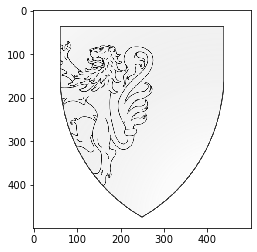

Caption: image_12.png
Caption: image_13.png
Caption: image_14.png
Caption: image_15.png
Caption: image_16.png


In [2]:
#location of the data 
data_location =  '/home/space/datasets/COA/generated-data-api'
# data_location =  'generated-data-api'
!ls $data_location

#reading the text data 

caption_file = data_location + '/captions.txt'
df = pd.read_csv(caption_file)
print("There are {} image to captions".format(len(df)))
df.head(7)



#select any index from the whole dataset 
#single image has 5 captions
#so, select indx as: 1,6,11,16...
data_idx = 11

image_path = data_location + '/images/'+ df.iloc[data_idx,0]
img=mpimg.imread(image_path)
plt.imshow(img)
plt.show()

#image consits of 5 captions,
#showing all 5 captions of the image of the given idx 
for i in range(data_idx,data_idx+5):
    print("Caption:", df.iloc[i,0])


# Split Data into Training/Test datasets 

In [3]:
train_annotation_file = data_location + '/train_captions.txt'
test_annotation_file  = data_location + '/test_captions.txt'

# Comment out to keep those for later to compare different models 


# train=df.sample(frac=0.8,random_state=200) #random state is a seed value
# test=df.drop(train.index)

# train.to_csv(train_annotation_file, sep=',',index=False)
# test.to_csv(test_annotation_file, sep=',',index=False)


In [4]:
#imports 
import os
import torch
import spacy
import torchvision.transforms as T
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader,Dataset
from PIL import Image
from datetime import datetime


from src.baseline.vocabulary import Vocabulary
from src.baseline.coa_dataset import CoADataset
from src.baseline.caps_collate import CapsCollate
from src.baseline.data_loader import get_loader


In [5]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=1)

# Image Captioning With Attention - Pytorch

In [6]:
#show the tensor image
def show_image(img, title=None):
    """Imshow for Tensor."""
    
    #unnormalize 
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406
    
    img = img.numpy().transpose((1, 2, 0))
    
    
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    

def print_time(text):
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    print("{} @ Time = {}".format(text, current_time))


In [7]:
#Initiate the Dataset and Dataloader

#setting the constants
BATCH_SIZE = 10
NUM_WORKER = 2
data_location =  '/home/space/datasets/COA/generated-data-api'

#defining the transform to be applied

transform = T.Compose([
    T.Resize(226),                     
    T.RandomCrop(224),                 
    T.ToTensor(),                               
    T.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
])

print_time('writing the dataloader')

train_loader, test_loader, train_dataset, test_dataset = get_loader(
    root_folder=data_location+"/images",
    train_annotation_file=data_location+"/train_captions.txt",
    test_annotation_file=data_location+"/test_captions.txt",
    transform=transform,
    num_workers=2
)

print_time('finished writing the dataloader')

#loading dataset @ Time = 15:34:44
#finished loading dataset @ Time = 16:06:18
#writing the dataloader @ Time = 16:06:18
#finished writing the dataloader @ Time = 16:06:18


writing the dataloader @ Time = 17:11:37
finished writing the dataloader @ Time = 17:42:28


In [8]:
len(train_loader), len(test_loader), len(train_dataset), len(test_dataset)

(268, 67, 8554, 2138)

In [10]:
train_dataset.vocab.stoi

{'<PAD>': 0,
 '<SOS>': 1,
 '<EOS>': 2,
 '<UNK>': 3,
 'g': 4,
 'v': 5,
 'b': 6,
 'cross': 7,
 'lion': 8,
 'passt': 9,
 's': 10,
 'a': 11,
 'eagle': 12,
 'o': 13,
 'doubleheaded': 14,
 "'s": 15,
 'head': 16,
 'patonce': 17,
 'moline': 18,
 'guard': 19,
 'rampant': 20}

In [11]:
train_dataset.vocab.itos

{0: '<PAD>',
 1: '<SOS>',
 2: '<EOS>',
 3: '<UNK>',
 4: 'g',
 5: 'v',
 6: 'b',
 7: 'cross',
 8: 'lion',
 9: 'passt',
 10: 's',
 11: 'a',
 12: 'eagle',
 13: 'o',
 14: 'doubleheaded',
 15: "'s",
 16: 'head',
 17: 'patonce',
 18: 'moline',
 19: 'guard',
 20: 'rampant'}

### Defining the Model Architecture

Model is seq2seq model. In the **encoder** pretrained ResNet model is used to extract the features. Decoder, is the implementation of the Bahdanau Attention Decoder. In the decoder model **LSTM cell**.

https://blog.floydhub.com/attention-mechanism/

In [12]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,Dataset

from src.baseline.model import EncoderCNN, Attention, DecoderRNN, EncoderDecoder


### Setting Hypperparameter and Init the model

In [16]:
#Hyperparams
embed_size=300
vocab_size = len(train_dataset.vocab)
attention_dim=256
encoder_dim=2048
decoder_dim=512
learning_rate = 3e-4


In [17]:
# initialize model, loss etc
model = EncoderDecoder(embed_size, vocab_size, attention_dim, encoder_dim, decoder_dim, drop_prob=0.3).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=train_dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [20]:
%pip install nltk

     |████████████████████████████████| 1.5 MB 1.8 MB/s eta 0:00:01
     |████████████████████████████████| 306 kB 3.7 MB/s eta 0:00:01
     |████████████████████████████████| 764 kB 3.7 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [25]:
import nltk

def test_function(model, test_loader):
    model.eval()
    bleu_score = 0
    # f = open("results.txt", "w")
    for idx, (images, correct_captions) in enumerate(iter(test_loader)):
        features = model.encoder(images.to(device))
        for i in range(features.shape[0]):
            caps, alphas = model.decoder.generate_caption(features[i:i+1], vocab=train_dataset.vocab)
            caps = caps[:-1].T
            caption = ' '.join(caps)
            correct_caption = []
            for j in correct_captions.T[i:i+1][0]:
                if j.item() not in [0, 1, 2]:
                    correct_caption.append(test_dataset.vocab.itos[j.item()])
            bleu = nltk.translate.bleu_score.sentence_bleu([correct_caption.T], caps, weights=(0.5, 0.5))
            correct_caption = ' '.join(correct_caption.T)
            write_this = correct_caption + ', ' + caption + '\n'
            bleu_score += bleu
            # f.write(write_this)
    # f.close()
    return bleu_score/8091

#helper function to save the model
def save_model(model,num_epochs, model_full_path):
    model_state = {
        'num_epochs':num_epochs,
        'embed_size':embed_size,
        'vocab_size':len(train_dataset.vocab),
        'attention_dim':attention_dim,
        'encoder_dim':encoder_dim,
        'decoder_dim':decoder_dim,
        'state_dict':model.state_dict()
    }

    torch.save(model_state,model_full_path)

## Training Job from above configs

In [ ]:
num_epochs = 25
print_every = 100
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

for epoch in range(1, num_epochs + 1):
    model.train()

    for idx, (image, captions) in enumerate(iter(train_loader)):
        image, captions = image.to(device), captions.to(device)
        # Zero the gradients.
        optimizer.zero_grad()
        # Feed forward
        outputs, attentions = model(image, captions.T)
        # Calculate the batch loss.
        targets = captions.T[:,1:]  ####### the fix in here
        loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))
        # Backward pass.
        loss.backward()
        # Update the parameters in the optimizer.
        optimizer.step()
        if (idx+1)%print_every == 0:
            print("Epoch: {} loss: {:.5f}".format(epoch,loss.item()))
    
    print(test_function(model, test_loader))

    #save the latest model
    save_model(model, epoch, '/home/space/datasets/COA/models/baseline/attention_model_state.pth')

##  Visualizing the attentions
Defining helper functions
<li>Given the image generate captions and attention scores</li>
<li>Plot the attention scores in the image</li>

In [41]:
import torch
import torch.onnx as onnx
import torchvision.models as models

def load_trained_model(model_path):
    # the values here are unimportant as they will be overwritten later
    model = EncoderDecoder(
        embed_size=300,
        vocab_size = len(dataset.vocab),
        attention_dim=256,
        encoder_dim=2048,
        decoder_dim=512
    ).to(device)

    torch.save(model.state_dict(),model_path)
    
    return model

model_path = '/home/space/datasets/COA/models/baseline/attention_model_state.pth'
model = load_trainder_model(model_path)

In [42]:
#generate caption
def get_caps_from(features_tensors):
    #generate the caption
    model.eval()
    with torch.no_grad():
        features = model.encoder(features_tensors.to(device))
        caps,alphas = model.decoder.generate_caption(features,vocab=dataset.vocab)
        caption = ' '.join(caps)
        show_image(features_tensors[0],title=caption)
    
    return caps,alphas

#Show attention
def plot_attention(img, result, attention_plot):
    #untransform
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406
    
    img = img.numpy().transpose((1, 2, 0))
    temp_image = img

    fig = plt.figure(figsize=(15, 15))

    len_result = len(result)
    for l in range(len_result):
        temp_att = attention_plot[l].reshape(7,7)
        
        ax = fig.add_subplot(len_result//2,len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.7, extent=img.get_extent())
        

    plt.tight_layout()
    plt.show()

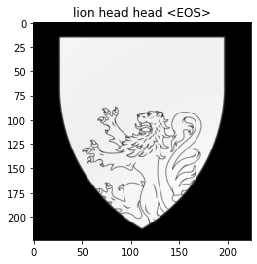

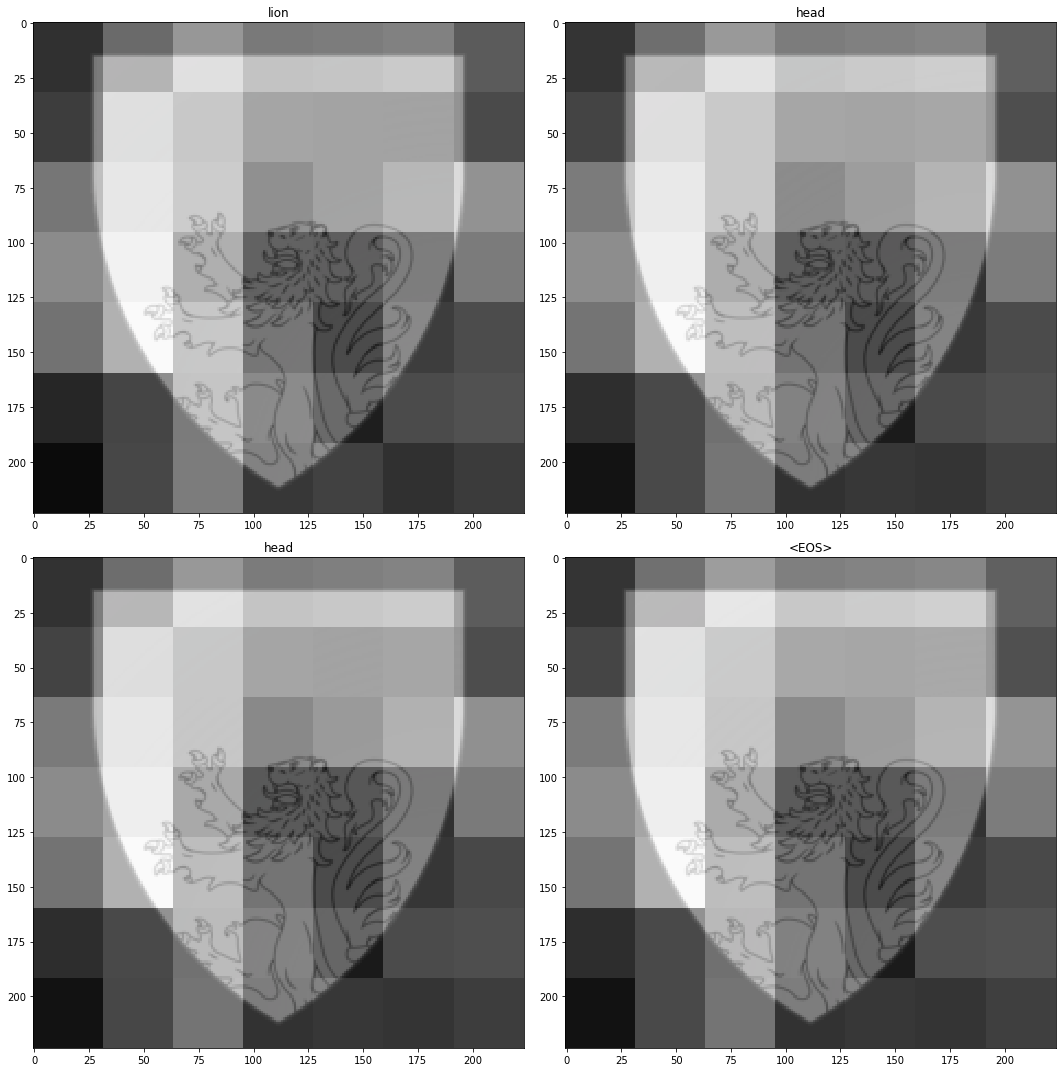

In [43]:
#show any 1
dataiter = iter(data_loader)
images,_ = next(dataiter)

img = images[0].detach().clone()
img1 = images[0].detach().clone()
caps,alphas = get_caps_from(img.unsqueeze(0))

plot_attention(img1, caps, alphas)

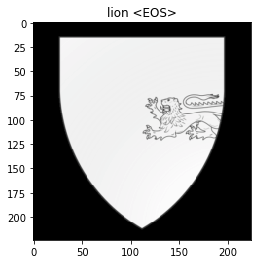

ValueError: num must be 1 <= num <= 1, not 2

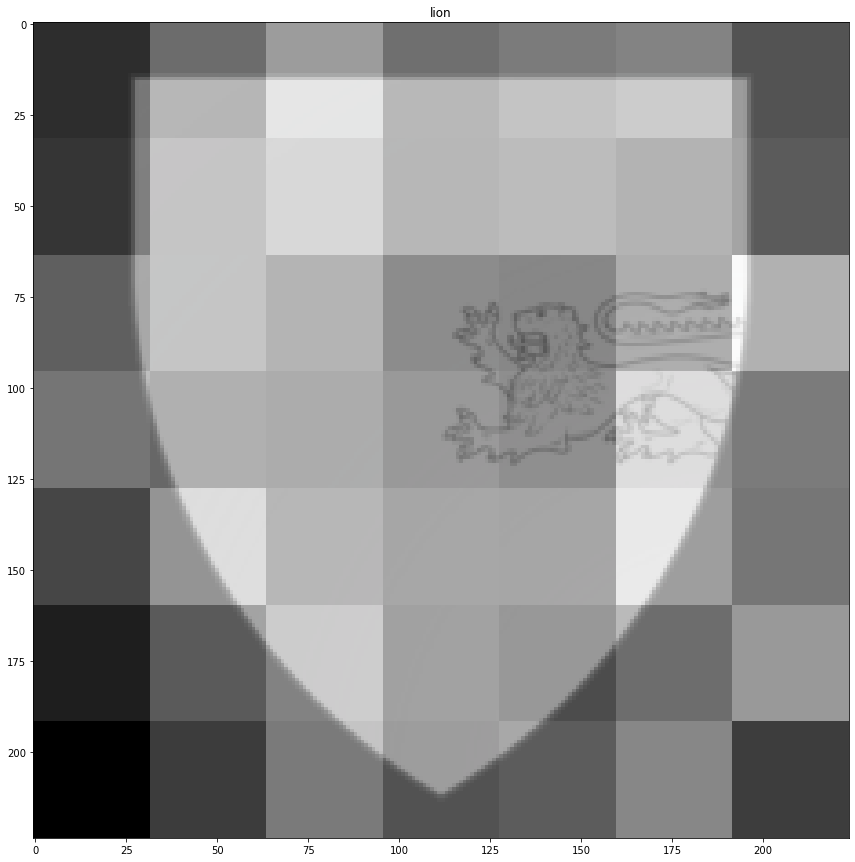

In [45]:
#show any 1
dataiter = iter(data_loader)
images,_ = next(dataiter)

img = images[0].detach().clone()
img1 = images[0].detach().clone()
caps,alphas = get_caps_from(img.unsqueeze(0))

plot_attention(img1, caps, alphas)

In [ ]:
#show any 1
dataiter = iter(data_loader)
images,_ = next(dataiter)

img = images[0].detach().clone()
img1 = images[0].detach().clone()
caps,alphas = get_caps_from(img.unsqueeze(0))

plot_attention(img1, caps, alphas)

In [ ]:
#show any 1
dataiter = iter(data_loader)
images,_ = next(dataiter)

img = images[0].detach().clone()
img1 = images[0].detach().clone()
caps,alphas = get_caps_from(img.unsqueeze(0))

plot_attention(img1, caps, alphas)

In [ ]:
#show any 1
dataiter = iter(data_loader)
images,_ = next(dataiter)

img = images[0].detach().clone()
img1 = images[0].detach().clone()
caps,alphas = get_caps_from(img.unsqueeze(0))

plot_attention(img1, caps, alphas)

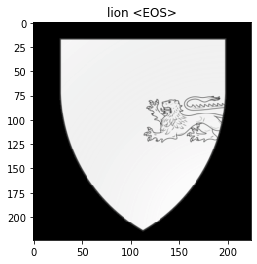

ValueError: num must be 1 <= num <= 1, not 2

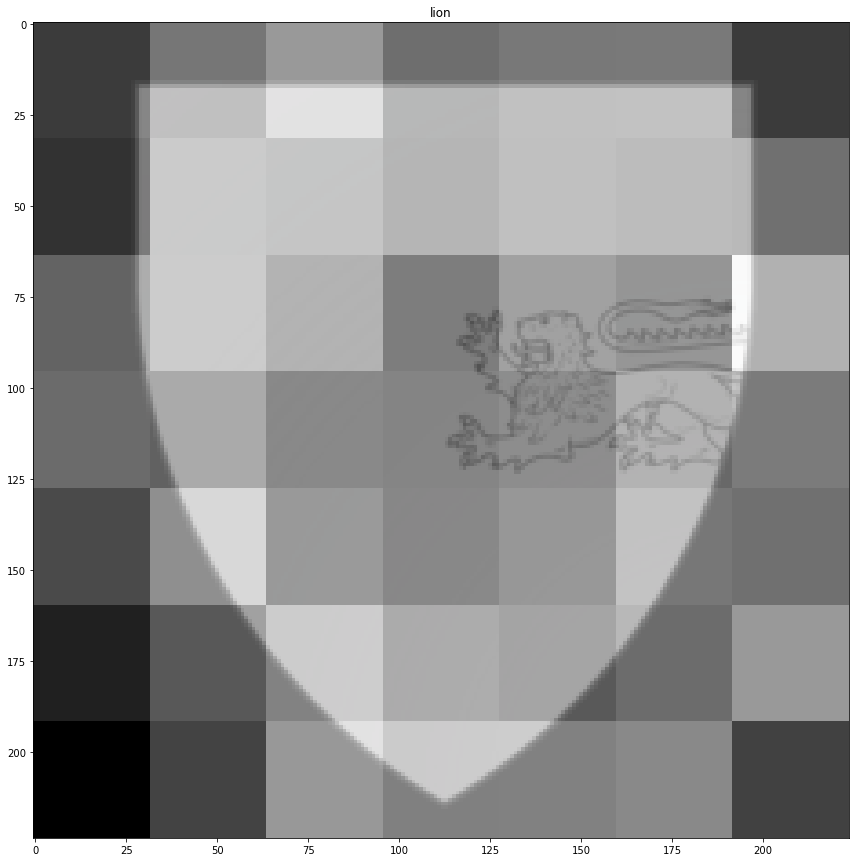

In [46]:
#show any 1
dataiter = iter(data_loader)
images,_ = next(dataiter)

img = images[0].detach().clone()
img1 = images[0].detach().clone()
caps,alphas = get_caps_from(img.unsqueeze(0))

plot_attention(img1, caps, alphas)